# Trabajo: Detección de texturas

El objetivo de esta actividad es profundizar en la detección de texturas y en el uso de descriptores basados en entropía.

Los puntos que trataremos serán los siguientes:
* Librerías, preprocesado y visualizacion de imagen
* Implementación de la función de entrpía
* Calculo de entropía para conjuntos de píxeles de tamaño variable (3x3,5x5,7x7)
* Analisis y comparación de los resultados

## Importación de librerías y carga de imagen

shape = (512, 512)


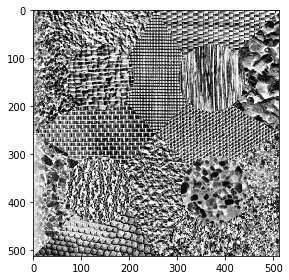

In [23]:
# Librerías
from skimage import data
from skimage import io
from skimage.transform import resize
from skimage import color
from math import log

import matplotlib.pyplot as plt
import numpy as np

# Cargamos la imagen
s = "tema5_actividad.png"
myim = io.imread(s)

# La imagen tiene 3 canales asi que hacemos un cambio a gris
im = color.rgb2gray(myim)
print('shape = {}'.format(im.shape))

# la mostramos
io.imshow(im)

## Implementación de la funcion entropia

Para la función entropía vamos a ejecutar los siguientes pasos:
* Selección de la región de la imagen variable (según el numero de vecinos)
* Histograma de la región
* Calculo de entropia tras el cálculo probabilidades y logaritmos (pa = Na/Len)

Dado que el algoritmo es un poco lento de ejecutar en toda la imagen hemos hecho una función alternativa (LocalEntropy_fast) que simplemente es igual a la original (localEntropy) pero eliminando todo lo innecesario

In [24]:
sh = im.shape
milen = sh[0]*sh[1]
print('Forma de la matriz imagen: \t {}'.format(sh))
print('Número de píxeles totales: \t {} píxeles'.format(milen))

Forma de la matriz imagen: 	 (512, 512)
Número de píxeles totales: 	 262144 píxeles


In [25]:
# --- Definimos la función del calculo de la entropia
def LocalEntropy(Im,n,x,y,bins,info):
    """
    Funcion que calcula la entropia local de una imagen
    Im = Imagen en escala de grises
    n = tamaño de la celdilla 
    x = posicion X del pixel a calcular
    Y = posicion Y del pixel a calcular
    info = 0 -> Devolvemos solo la entropía
    info = 1 -> Devolvemos mas información 
    """

    # seleccionamos la matriz correspondiente
    localm = Im[(y-n):(y+n+1),(x-n):(x+n+1)] 
    hist, bin_edges = np.histogram(localm,bins) #print(hist,bin_edges)
    #Calculamos la entropía como suma de probabilidades por su logaritmo
    sump = 0
    mlen = (n+2)*(n+2)
    
    for i  in hist:
        if (i!=0):
            pp = i/(mlen)   # probabilidad parcial
            lpp = log(pp) # log probabilidad parcial
            prod = pp*lpp # hacemos el producto
            sump += prod  # calculamos entropia
            #print(pp)
            #print(prod)     
    ent = -1*sump
    if (info==1):
        return ent,localm,hist,bin_edges
    else:
        return ent

# --------------------------------------------------------------
# La función a continuación se basa en la propiedad multiplicativa de matrices 
# para evitar hacer sumas parciales y logartimos de cada termino

def LocalEntropy_fast2(Im,n,x,y,bins):
    """
    Funcion que calcula la entropia local de una imagen
    Im = Imagen en escala de grises, n = tamaño de la celdilla 
    x,y = posicion X,Y del pixel a calcular
    """
    mlen = (n+2)*(n+2)
    
    # seleccionamos la matriz correspondiente
    localm = Im[(y-n):(y+n+1),(x-n):(x+n+1)] 
    t, bin_edges = np.histogram(localm,bins) 
    t = t[t != 0]
    t = t/mlen
    ent = -np.dot(t,np.log(t.T))
     
    return ent

# --------------------------------------------------------------

# Funcion para iterar en toda la imagen
def iter_LocalEntropy(Im,n,bins,sh):
    """"
    Función que itera la entropía en toda la imagen
    Im,n,bins,sh -> Imagen, tamaño celdilla, número de bins para el histograma, shape de la imagen
    """
    aux = np.zeros((sh[0],sh[1]))
    
    # hacemos una iteracion en toda la imagen
    for j in range(n,sh[0]-n):
        for i in range(n,sh[1]-n):
            aux[j,i] = LocalEntropy_fast2(im,n,i,j,bins)
    
    return aux

## Calculo de entropía para conjuntos de píxeles de tamaño variable (3x3,5x5,7x7)

In [30]:
# hacemos una iteración para los distintos tamaños de celdilla
a = 0
bins = 10
sh = im.shape
new = np.zeros((3,sh[0],sh[1]))

# bucle con los distintos tamaños de vecindades
for i in [3,5,7]:
    size = i # 3X3
    n = size // 2
    print(n)
    
    # llamada a la función para calcular entropia local
    new[a,:,:] = iter_LocalEntropy(im,n,bins,sh) 
    a+= 1
    
    # lo arreglamos
    arr = aux2[n:-n,n:-n]
    new_arr = ((arr - arr.min()) * (1/(arr.max() - arr.min()) * 255)).astype('uint8')
        
print('\nfin de las operaciones')

1
2
3

fin de las operaciones


##  Analisis y comparación de los resultados

1
2
3


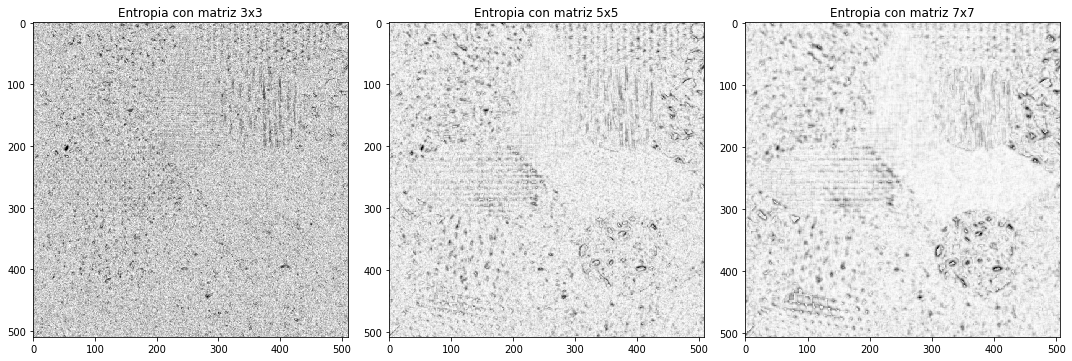

In [42]:
a = 0
plt.figure(1,figsize=(15,15))

# hacemos un bucle que va truncando y "ploteando" los resultados
for i in [3,5,7]: 
    size = i # 3X3, 5x5, 7x7...
    n = size // 2
    print(n)
        
    # lo arreglamos quitando los bordes (quitamos los 0)
    arr = new[a,n:-n,n:-n]
    new_arr = ((arr - arr.min()) * (1/(arr.max() - arr.min()) * 255)).astype('uint8')
    
    # dibujamos los resultados
    a += 1
    ax = plt.subplot(1,3,a)
    ax.set_title('Entropia con matriz {}x{}'.format(i,i))


    io.imshow(new_arr)


Podemos ver como para las vecindades de mayor tamaño obtenemos mejores resultados. En general, no nos resulta un método muy efectivo para separar regiones. Estas regiones tienen una alta granuralidad de por sí. 

Si mejoramos el contraste y elegimos los bin de una forma mas precisa obtendremos mejores resultados 

Hemos probado con otras imágenes mas homogéneas coo un paisaje con distintas regiones y se consiguen distinguir mucho mejor las regiones. 

A modo de conclusión por lo que se ha observado la separación de regiones por entropía es un método útil, facil de implementar,
pero no funciona bien en algunos casos concretos. Depende de la imagen a analizar y hace falta ajuste y supervisión por parte humana, no es un método universal. 